In [18]:
import xlrd
import os
import numpy as np
import pandas as pd
import numpy as np

def write_all():
    workbook = xlrd.open_workbook("Closed End Fixed Income.xlsx")
    names = workbook.sheet_names()
    for x in range(0,workbook.nsheets):
        sheet = workbook.sheet_by_index(x)
        df = pd.DataFrame([sheet.row_values(x) for x in range(1, sheet.nrows)])
        df.columns = df.iloc[0]
        df = df[1:]
        name = names[x]
        if name not in ["HYG Index", "JNK Index"]:
            df.to_csv("funds_fixed_income/"+name.upper()+".csv")


In [19]:
def create_hf():   
    hf = pd.DataFrame({})
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    for x in my_dir:
        df = pd.read_csv("./funds_fixed_income/"+x)
        name = x.split(".csv")[0]
        cf = df["ID.WEIGHTS"].to_frame(name)
        #.iloc[:,-1]
        cf.index = df["ID"].replace(np.nan, "N/A")
        cf = cf.dropna(axis=0)
        na = cf[cf.index=="N/A"].astype('float').sum(axis=0)
        na += cf.iloc[cf.index.str[:4]=="#N/A"].sum(axis=0)
        cf = cf[(cf.index != "N/A") & (cf.index.str[:4]!="#N/A")]
        cf.loc["N/A"] = na
        cf = cf.groupby(level=0).sum()
        hf = hf.merge(cf, how='outer', left_index=True, right_index=True)


    hf = hf.fillna(0)
    hf = hf.astype('float')
    hf = hf.div(hf.sum(), axis=1)*100
    return hf
hf = create_hf()


In [20]:
def create_index():
    tf = pd.read_csv("./jnk_index.csv")
    sf = tf[["ID", "ID.WEIGHTS", "Unnamed: 11"]]
    sf.columns = ["Symbol","Weight", "Ticker"]
    return sf


In [33]:
def create_discount_df():
    global hf
    funds = hf.columns
    df = pd.read_csv("Discount.csv", index_col=0)
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)].iloc[:,:4]
    df = df.apply(lambda x: [x["Discount"].strip("%"),x["52W Discount"].strip("%"), x["Effective"].strip("%"), x["Distribution Rate"].strip("%")], axis=1, result_type='expand')
    df = df.replace("--",0)
    df.columns = ["Discount", "52W Discount", "Effective","Distribution"]
    df = df.astype('float')
    df["Discount_Weights"] = (((-df["Discount"]+ (-df["Discount"] + df["52W Discount"]))+20)/100)*2
    discount_df = df.reindex([x.upper() for x in hf.columns])
    return discount_df
create_discount_df()


,Discount,52W Discount,Effective,Distribution,Discount_Weights
Ticker,,,,,
NHS,-8.15,-6.14,33.59,9.35,1.9155
HIO,-8.73,-9.01,0.00,7.77,1.8590
MPV,-8.82,-3.67,7.16,6.53,2.1395
DHY,-8.96,-9.70,27.82,8.67,1.8590
MCI,-9.04,-4.85,6.87,7.29,2.1135
AWF,-9.44,-11.92,0.05,6.71,1.8200
DHF,-9.48,-11.02,28.12,8.72,1.8710
BGH,-9.70,-9.64,21.55,8.46,1.9730
EAD,-9.82,-11.07,23.13,8.31,1.9195


In [34]:


def change_down(weights, find, no_change_nums):
    k = [x + (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]-.01)
    for x in no_change_nums:
        k[x] = weights[x]
    return k


def change_up(weights, find, no_change_nums):
    l = weights
    k = [x - (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]+.01)
    for x in no_change_nums:
        k[x] = weights[x]
    negs = abs(sum(list(filter(lambda x: max(x,0)==0, k))))
    zeros = list(filter(lambda x: max(k[x],0)==0, range(len(k))))
    for x in zeros:
        k[x] = 0
    zeros.append(find)
    zeros = zeros + no_change_nums
    not_zeros = list(filter(lambda x: x not in zeros, range(len(k))))
    for x in not_zeros:
        k[x] = k[x] - (negs/len(not_zeros))
    if negs != 0 and not_zeros == []:
        return False
    return k

def find(weights):
    global hf
    global sf
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    w = [max(x,0) for x in weights]
    val = sum(discount_df['Discount_Weights'] * w)
    [max(x,0) for x in weights]
    close_val = (100/(abs(sum(filter(lambda x: x < 0, df["Weight"]-df["ours"])))))*100
    return close_val * val

def best(type, weights, ideal, ideal_weights):
    if weights == False:
        return ideal_weights
    if list(filter(lambda x: x < 0, weights)) != list():
        return ideal_weights
    global no_change_nums
    global find_num
    num = find(weights)
    if num > ideal:
        if type == "up":
            if weights[find_num] + .01 > 0:
                return best("up",  change_up(weights, find_num, no_change_nums), num, weights)
            else:
                return weights
        if type == "down":
            if weights[find_num] - .01 > 0:
                return best("down", change_down(weights, find_num, no_change_nums), num, weights)
            else: 
                return weights
    else:
        return ideal_weights
    
    
def go_through(weights):
    global no_change_num
    global find_num
    num = find(weights)
    dw = change_down(weights, find_num, no_change_nums)
    uw = change_up(weights, find_num, no_change_nums)
    if uw == False and dw == False:
        return weights
    elif uw == False:
        return best("down", dw,num, weights)
    elif dw == False:
        return (best("up", uw,num, weights))
    up = find(uw)
    down = find(dw)
    if up > down and up > num:
        return (best("up", uw,num, weights))
        
    elif down > num:
        return best("down", dw,num, weights)
    else:
        return weights
    
        




In [35]:
def do(way):
    global find_num
    global no_change_nums
    weights = [1/len(hf.columns) for x in range(len(hf.columns))]
    n = 0
    for x in way:
        find_num = x[0]
        no_change_nums = x[1]
        weights = go_through(weights)
        n+=1
    return weights

In [36]:
def path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y+1)
    


def path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y-1)

def weird_path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y-1)
    
def weird_path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y+1)

def way1(): 
    global z
    z = len(hf.columns)-1
    return path(0) + weird_path2(z)
    
def way2():
    global z
    z = len(hf.columns)-1
    return path(0) + path2(z)

def way3():
    global z
    z = len(hf.columns)-1
    return path2(z) + path(0)

def way4(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + weird_path(0)

def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way6(): 
    global z
    z = len(hf.columns)-1
    return path(0) + [7,[]] + path(0)
def way7(): 
    global z
    z = len(hf.columns)-1
    return path2(z)
def way8(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + [0,[]] + path2(z)
paths = [way1,way2,way3,way4]


In [37]:
def create_assets(weights):
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    tf = df[df['Weight']!=0]
    not_in = df[df['Weight']==0]["ours"].sum()
    tf = tf.rename(columns={"Weight":"Index"})
    tf = tf.sort_values(by=['ours'], ascending=False)
    i = pd.DataFrame([[not_in, 0]], ["notINs&p500"], columns=["ours","Index"])
    tf = tf.append(i)
    return tf

def how_much():
    global tf
    tf["more"] = tf["Index"] -tf["ours"]
    amount_more = abs(tf[tf["more"]<0]["more"]).sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    amount_sp500 = (100/(abs(tf[tf["more"]<0]["more"]).sum()+100))
    amount_buy = tf[tf["more"]>0]["more"].sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    return amount_sp500

def avg_discount():
    df = discount_df.reindex(hf.columns,axis=0)
    df["Weights"] = weights
    avg_discount = (df["Discount"]*df["Weights"]).sum()*amount_sp500
    return avg_discount

def avg_effective():
    df2 = discount_df.reindex(hf.columns,axis=0)
    df2["Weights"] = weights
    avg_discount = (df2["Effective"]*df2["Weights"]).sum()*amount_sp500
    return avg_discount

def avg_distribution():
    avg_discount = (discount_df["Distribution"]*weights).sum()
    return avg_discount

In [38]:
how_much_dis = [100, 0, -1, -2, -3,-4,-5,-6,-7,-8,-9,-10]
final = pd.DataFrame(columns=["Weights"])
dicty = []
path_num = 0
hf_orig = create_hf()
sf_orig = create_index()
hf = hf_orig
discount_df_orig = create_discount_df()


global discount_df
global weights

for way in paths:
    path_num += 1
    hf = hf_orig
    sf = sf_orig
    discount_df = discount_df_orig
    print(len(discount_df))
    print("NEXT")
    while True:
        if len(discount_df) == 20:
            break
        
        weights = do(way())

        weights = [round(x,5) for x in weights]
        weights_not_zero = list(filter(lambda x: x > 0,weights))
        if len(weights_not_zero) <= 2:
            break
        tf = create_assets(weights)
        
        amount_sp500 = how_much()
        print(amount_sp500)
        
        average_discount = avg_discount()
        average_effective = avg_effective()
        average_distribution = avg_distribution()
        print(average_discount)
        df = discount_df.reindex(hf.columns,axis=0)
        df["Weights"] = weights
        df["hmd"] = str(path_num)+ "," + str(len(discount_df))
        df.index = pd.MultiIndex.from_frame(df.reset_index()[["hmd","index"]])
        final = pd.concat([final, df[["Weights"]]])
        dicty.append({
            "which": (str(path_num), str(len(discount_df))),
            "x":amount_sp500*100,
            "y": average_discount,
            "effective": average_effective,
            "distribution": average_distribution
        })
        discount_df = discount_df.sort_values(by=["Discount"], ascending=False)
        discount_df = discount_df.iloc[1:]
        hf = hf[discount_df.index]
       

final.index = pd.MultiIndex.from_tuples(final.index)

39
NEXT
0.6221682121268147
-6.084532667140157
0.6335318533231789
-6.65811682349435
0.632301703966881
-7.010990948534693
0.6308336542433051
-6.513230493247525
0.6314586662762501
-6.65365818122886
0.6332732489685782
-6.505574923893021
0.6339640028732471
-6.58218482978973
0.6333051956119414
-6.533283426510845
0.6341815388596134
-6.548146352264108
0.6335844108917976
-6.5570452801056325
0.6339681347818673
-6.5640273286891135
0.633212343050881
-6.577874660556481
0.6340253293364387
-6.603271219740723
0.6334634381164259
-6.6373779605819845
0.6327486181979537
-6.689077276808696
0.6342989868313186
-6.713294441413993
0.6334209682819087
-6.724255746404815
0.6344137823817284
-6.7312304684477535
0.6332178589167622
-6.766086821108892
39
NEXT
0.635825091946753
-5.687645495583689
0.639398116351503
-6.231991121353044
0.6152411601863875
-7.033465798061197
0.6306145299584841
-6.726427307801998
0.6257626091028309
-6.760492302821432
0.6332961452631536
-6.901626179812172
0.6366614702107374
-6.875414366931188

In [27]:
final.to_csv("final.csv")
k = pd.read_csv("../flask/hy_fixed_income/dataframes/final.csv", index_col=[0,1])
k.head()

Weights
1,38 CIF   0.08632
     EHT   0.00956
     JCO   0.00984
     BGIO  0.00012
     JHB   0.00100

In [39]:
hey = list(dicty)
# and t["distribution"] > y["distribution"] and t["effective"] < y["effective"]
t = list(dicty)
for y in hey:
    if list(filter(lambda t: t["x"] > y["x"] and t["y"] < y["y"], hey)) != []:
        t.remove(y)

t

[{'which': ('2', '38'),
  'x': 63.9398116351503,
  'y': -6.231991121353044,
  'effective': 16.779308583178558,
  'distribution': 8.342329399999999},
 {'which': ('2', '33'),
  'x': 63.66614702107374,
  'y': -6.875414366931188,
  'effective': 15.812697014812477,
  'distribution': 8.2470942},
 {'which': ('2', '31'),
  'x': 63.2726886597133,
  'y': -7.070026515238885,
  'effective': 16.16481323484047,
  'distribution': 8.1024285},
 {'which': ('2', '22'),
  'x': 62.95795128164653,
  'y': -7.136117128077591,
  'effective': 16.02225080404494,
  'distribution': 8.023229400000002},
 {'which': ('3', '33'),
  'x': 63.10905331332302,
  'y': -7.100240932121943,
  'effective': 16.156722099313278,
  'distribution': 8.039940600000001},
 {'which': ('3', '25'),
  'x': 63.386251432916005,
  'y': -7.0636993324802,
  'effective': 15.86262918122095,
  'distribution': 8.2127818},
 {'which': ('4', '37'),
  'x': 55.627229210224186,
  'y': -7.685563456911156,
  'effective': 10.649927042314784,
  'distribution':

In [29]:
import json
with open('../flask/hy_fixed_income/dataframes/dicty.json', 'w') as outfile:
    json.dump(t, outfile)

In [30]:
dicty

[{'which': ('1', '39'),
  'x': 63.395302251681194,
  'y': -6.233323568143462,
  'effective': 16.498518180894255,
  'distribution': 8.4634005},
 {'which': ('1', '38'),
  'x': 63.79164928385149,
  'y': -4.570194254484719,
  'effective': 16.552487151428444,
  'distribution': 8.532148400000002},
 {'which': ('1', '37'),
  'x': 62.62941987780529,
  'y': -4.856255217832902,
  'effective': 16.04416397417673,
  'distribution': 8.432096700000002},
 {'which': ('1', '36'),
  'x': 62.86859019733092,
  'y': -4.884822440415463,
  'effective': 16.175058533134404,
  'distribution': 8.4584046},
 {'which': ('1', '35'),
  'x': 63.00698560725713,
  'y': -4.978942805187579,
  'effective': 16.271108825713856,
  'distribution': 8.474833299999998},
 {'which': ('1', '34'),
  'x': 63.4251210176036,
  'y': -4.961385250041482,
  'effective': 16.5058942339647,
  'distribution': 8.4316252},
 {'which': ('1', '33'),
  'x': 63.58389022241908,
  'y': -5.033763767895294,
  'effective': 16.703114978329445,
  'distribution

<IPython.core.display.Javascript object>


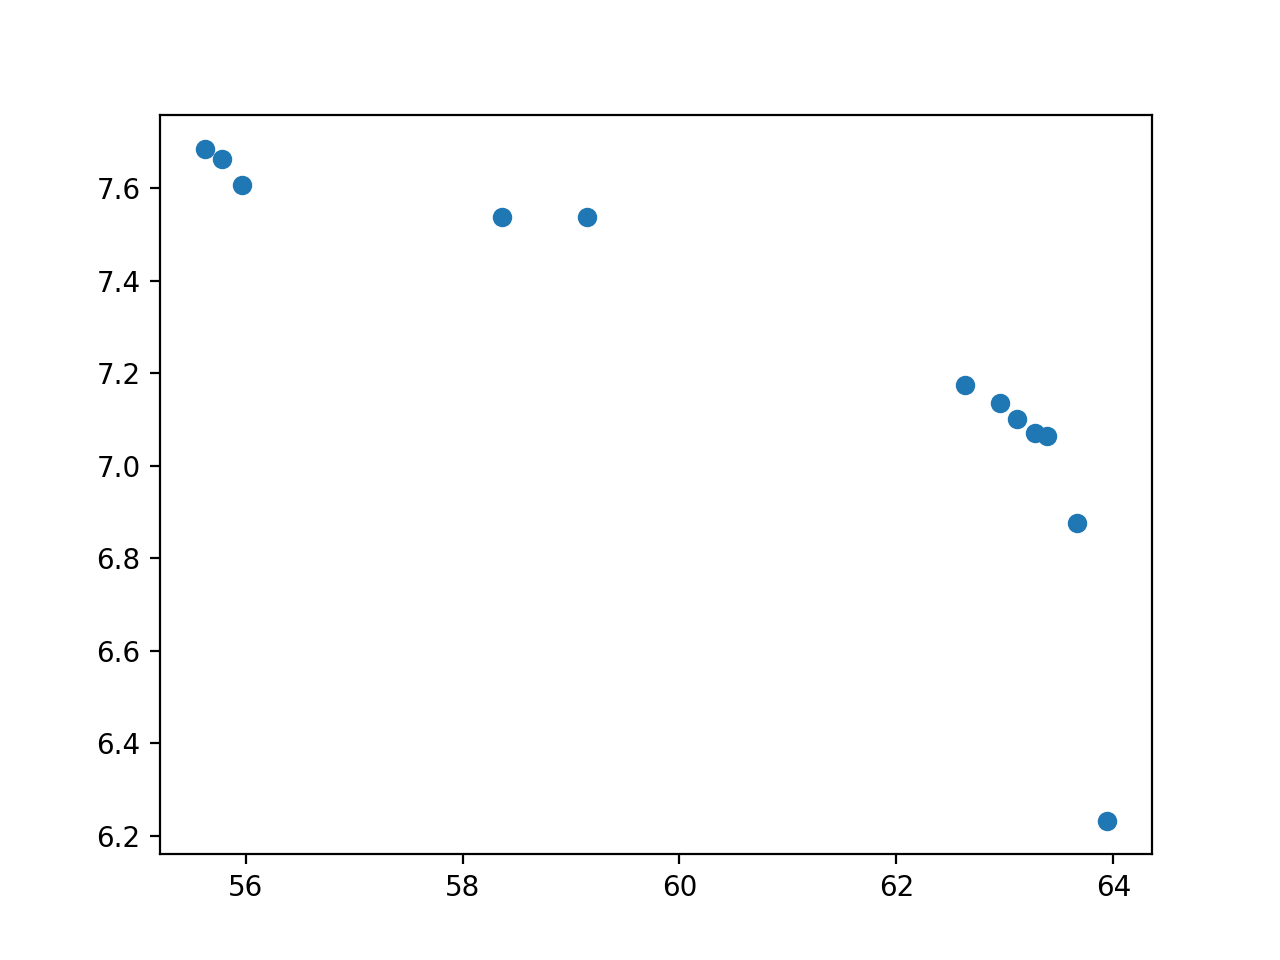

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot([x["x"] for x in t],[abs(x["y"]) for x in t],"o")
plt.show()

In [32]:
def final_df():
    global hf
    funds = hf.columns
    df = pd.read_csv("Discount.csv", index_col=0)
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)].iloc[:,:4]
    df = df.apply(lambda x: [x["Discount"].strip("%"),x["52W Discount"].strip("%"), x["Effective"].strip("%"), x["Distribution Rate"].strip("%")], axis=1, result_type='expand')
    df = df.replace("--",0)
    df.columns = ["Discount", "52W Discount", "Effective","Distribution"]
    df = df.astype('float')
    
    return df


df = final_df()
i = final.iloc[final.index.get_level_values(0) == '1,38']

#list(filter(lambda x: x not in list(i.index.get_level_values(1)), df.index))
i.index = i.index.get_level_values(1)
df = i.merge(df, how="outer", right_index=True, left_index=True).fillna(0)

df = df.sort_values(by=["Weights"], ascending=False)
(df["Weights"]*df["Discount"]).sum()


-7.1642516